In [1]:
# This is used to read fits files 
from astropy.io import fits

# Useful for a bunch of stuff
import numpy as np

# Used for Log plots
from matplotlib.colors import LogNorm

# Prettier plots
import seaborn as sns

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats = ('png', 'retina')

# Used for median filter to handle noise
from scipy import ndimage

# Used to regrid data
from scipy.interpolate import griddata

# Used for Gaussian 2D fitting
from scipy import optimize

In [2]:
def extract_FITS(filename):
    '''
       Extracts the data cube from the FITS file.
       
       Arguments: 
           filename : name of the file including path
           
       Return variables:
           hdu_list : hdu_list[0].data contains the data cube array in order of wavelength, y, x
           Min      : the starting wavelength value in the cube in Angstroms
           Max      : the ending wavelength value in the cube in Angstroms
           Step     : the step size of the wavelength
           xlen     : the size of the horizontal axis of FOV in arcseconds
           ylen     : the size of the horizontal axis of FOV in arcseconds
    '''
    
    hdu_list = fits.open(filename)
    image, header = fits.getdata(filename, header=True)
    Min = header['CRVAL3']
    step = header['CD3_3']
    Max = Min +  (np.shape(image)[0] - 1) * step
    ypixel = len(hdu_list[0].data[0])
    xpixel = len(hdu_list[0].data[0][0])
    xlen = (header['CD1_1']**2 + header['CD2_1']**2)**(0.5) * xpixel * 3600
    ylen = (header['CD1_2']**2 + header['CD2_2']**2)**(0.5) * ypixel * 3600
    return hdu_list, Min, Max, step, xlen, ylen

def wave2pix(wave, color):
    '''
       Converts a given wavelength value into the corresponding pixel of the specified cube.
       
       Arguments:
           wave     : the wavelength value 
           color    : blue, blue1, blue2, green, green1, green2, red, red1, red2
                      (1 and 2 are newly re-reduced cubes)
                      
       Return variables: 
           pixel    : the pixel value 
    '''
    
    if color == "blue":
        return int((wave - Min_blue) / step_blue)
    
    if color == "blue1":
        return int((wave - Min_blue1) / step_blue1)
    
    if color == "blue2":
        return int((wave - Min_blue2) / step_blue2)
            
    if color == "green":
        return int((wave - Min_green) / step_green)
    
    if color == "green1":
        return int((wave - Min_green1) / step_green1)
    
    if color == "green2":
        return int((wave - Min_green2) / step_green2)
            
    if color == "red":
        return int((wave - Min_red) / step_red)
    
    if color == "red1":
        return int((wave - Min_red1) / step_red1)
    
    if color == "red2":
        return int((wave - Min_red2) / step_red2)
    
def make_sum(start_wv, end_wv, color):
    '''
       Makes a direct sum of a set of images in a specified wavelength span. 
       
       Arguments:
           start_wv : the starting wavelength value  
           end_wv   : the ending wavelength value
           color    : blue, blue1, blue2, green, green1, green2, red, red1, red2
                      (1 and 2 are newly re-reduced cubes)
        
       Return variables: 
           sum_img  : the summed image
                      for the newly re-reduced cubes, this is multiplied by 10 to keep 
                      the units consistent   
    '''
    
    sum_img = 0
    start = wave2pix(start_wv, color)
    end = wave2pix(end_wv, color)
    length = -start + end
    
    if color == "blue":
        for i in range(length+1):
            sum_img += hdu_list_blue[0].data[start + i]
    
    if color == "blue1":
        for i in range(length+1):
            sum_img += hdu_list_blue1[0].data[start + i]
        sum_img *= 10
            
    if color == "blue2":
        for i in range(length+1):
            sum_img += hdu_list_blue2[0].data[start + i]
        sum_img *= 10
            
    if color == "green":
        for i in range(length+1):
            sum_img += hdu_list_green[0].data[start + i]
            
    if color == "green1":
        for i in range(length+1):
            sum_img += hdu_list_green1[0].data[start + i]
        sum_img *= 10
            
    if color == "green2":
        for i in range(length+1):
            sum_img += hdu_list_green2[0].data[start + i]
        sum_img *= 10
            
    if color == "red":
        for i in range(length+1):
            sum_img += hdu_list_red[0].data[start + i]
            
    if color == "red1":
        for i in range(length+1):
            sum_img += hdu_list_red1[0].data[start + i]
        sum_img *= 10
            
    if color == "red2":
        for i in range(length+1):
            sum_img += hdu_list_red2[0].data[start + i]
        sum_img *= 10
            
    return sum_img

def plot_hist(sum_img, hist_range=0):
    '''
       Displays a histogram of a summed image. Useful for deciding the colorbar. 
       
       Arguments:
           sum_img      : the summed image  
           hist_range   : (optional) specify a particular range for the x-axis
        
       Return variables: 
           none
    '''
    
    plt.figure(figsize=(9,4))
    if hist_range: 
        plt.hist(sum_img.flatten(), 100, range=hist_range)
    else:
        plt.hist(sum_img.flatten(), 100)
    plt.show()
    
    
def plot_sum(sum_img, minpix, maxpix):
    '''
       Plots a summed image.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           none
    '''
    
    plt.imshow(sum_img, cmap='jet', vmin=minpix, vmax=maxpix, aspect=xlen/ylen)
    ax = plt.gca();
    plt.xlabel('x (pix)');
    plt.ylabel('y (pix)');
    plt.colorbar()
    
def make_log(sum_img):
    '''
        Turn non-positive pixels into 0.01 to allow plotting of log. 
        
        Arguments:
           sum_img      : the summed image 
        
       Return variables: 
           sum_img_log  : the log filtered summed image
    '''
    
    sum_img_log = np.copy(sum_img)
    for i in range(len(sum_img)):
        for j in range(len(sum_img[0])):
            if sum_img_log[i][j] <= 0:
                sum_img_log[i][j] = 0.01
                       
    return sum_img_log
                       
def plot_log(sum_img_log, minpix, maxpix, tick, extent=False):
    '''
       Plots a summed image with a log colorbar.
       
       Arguments:
           sum_img_log  : the log filtered summed image 
           minpix       : the min value of the colorbar 
           maxpix       : the max value of the colorbar
           ticks        : (array) set the ticks on the colorbar
           extent       : (optional) (array) used to plot log of a sliced image
                          [xlow, xhigh, ylow, yhigh]
        
       Return variables: 
           none
    '''  
    
    if not extent: 
        plt.imshow(sum_img_log, cmap='jet', vmin=minpix, vmax=maxpix, aspect=xlen/ylen, norm=LogNorm())
        ax = plt.gca();
        plt.xlabel('x (pix)');
        plt.ylabel('y (pix)');
        cbar = plt.colorbar(ticks=tick);
        cbar.ax.set_yticklabels(tick);
        
    else:
        # Re-defining aspect ratio for the sliced image 
        xxlen = xlen * len(sum_img_log[0]) / len(hdu_list_blue1[0].data[0][0])
        yylen = ylen * len(sum_img_log) / len(hdu_list_blue1[0].data[0])
        
        plt.imshow(sum_img_log, cmap='jet', vmin=minpix, vmax=maxpix, extent=extent, aspect=xxlen/yylen, norm=LogNorm())
        ax = plt.gca();
        plt.xlabel('x (pix)');
        plt.ylabel('y (pix)');
        cbar = plt.colorbar(ticks=tick);
        cbar.ax.set_yticklabels(tick);
    
def plot_gaussian_fit(sum_img, yxslice, minpix, maxpix, tick, hlabel=0.57):
    '''
       Fits a 2D gaussian to a given slice of an image (want to choose the brightest), 
       finds the center, and displays the fitted 2D gaussian in a log plot of the image. 
       
       Arguments:
           sum_img  : the summed image
           yxslice  : tuple of (ylow, yhigh, xlow, xhigh) to slice the data array
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           ticks    : (array) set the ticks on the colorbar
           hlabel   : (optional) tweak the horizontal position of the sliced image label
        
       Return variables: 
           (y, x)   : the center of the gaussian fit in pixels
    '''
    
    (ylow, yhigh, xlow, xhigh) = yxslice
    
    # Plotting the log of the image sliced to the brightest region
    sum_img_log = make_log(sum_img)            
    plot_log(sum_img_log[ylow:yhigh+1, xlow:xhigh+1], minpix, maxpix, tick)
    
    # Fitting a 2D gaussian only to the brightest region
    params = fitgaussian(sum_img[ylow:yhigh+1, xlow:xhigh+1])
    (height, y, x, width_y, width_x) = params
    print(params)
    fit = gaussian(*params)
    
    # Labeling fitted gaussian centers in terms of the sliced image
    plt.figtext(hlabel, 0.9, "y = {}, x = {}".format(round(y, 4), round(x, 4)), 
                size='12', horizontalalignment='center')

    # Drawing contours of the fitted gaussian
    plt.contour(fit(*np.indices(sum_img[ylow:yhigh+1, xlow:xhigh+1].shape)), 
                extent=[0, xhigh-xlow, 0, yhigh-ylow], cmap='cool', origin='lower')
    plt.show()
    
    # Labeling fitted gaussian centers in terms of the whole image
    plt.figtext(0.622, 0.9, "y = {}, x = {}".format(round(ylow + y, 4), round(xlow + x, 4)), 
                size='12', horizontalalignment='center')
    
    # Plotting the log of the full image
    plot_log(sum_img_log[25:170+1,10:37+1], minpix, maxpix, tick, [10, 37, 170, 25])
    
    # Drawing contours of the fitted gaussian
    plt.contour(fit(*np.indices(sum_img[ylow:yhigh+1, xlow:xhigh+1].shape)), extent=[xlow, xhigh, ylow, yhigh], 
                cmap='cool', origin='lower')
    plt.show()
    
    return (ylow + y, xlow + x)
    
    
def gaussian(height, center_x, center_y, width_x, width_y):
    '''
       Returns a 2D gaussian function with the given parameters.
       
        Arguments:
           height
           center_x
           center_y
           width_x
           width_y
           
       Return variables: 
           2D gaussian function with set parameters
    '''
    
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(-(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    '''
       Calculates the moments to obtain the gaussian parameters of a 2D distribution. 
       
       Arguments:
           data   : 2D data array
       
       Return variables:
           height, x, y, width_x, width_y
    '''

    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    '''
       Fits a 2D gaussian given a 2D data array. 
       
       Arguments:
           data   : 2D data array
       
       Return variables:
           height, x, y, width_x, width_y
    '''
    
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
# Update default figure and font size
plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams.update({'font.size': 10})

In [4]:
image_1 = "HH32_170614/kb170614_00176_icubes.fits"
hdu_list_blue1 , Min_blue1, Max_blue1, step_blue1, xlen, ylen = extract_FITS(image_1)
hdu_list_blue1.info()

print(Min_blue1, Max_blue1, step_blue1, xlen, ylen)

Filename: HH32_170614/kb170614_00176_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4514)   float32   
3462.25 4590.5 0.25 15.615252271222728 28.12550448853331


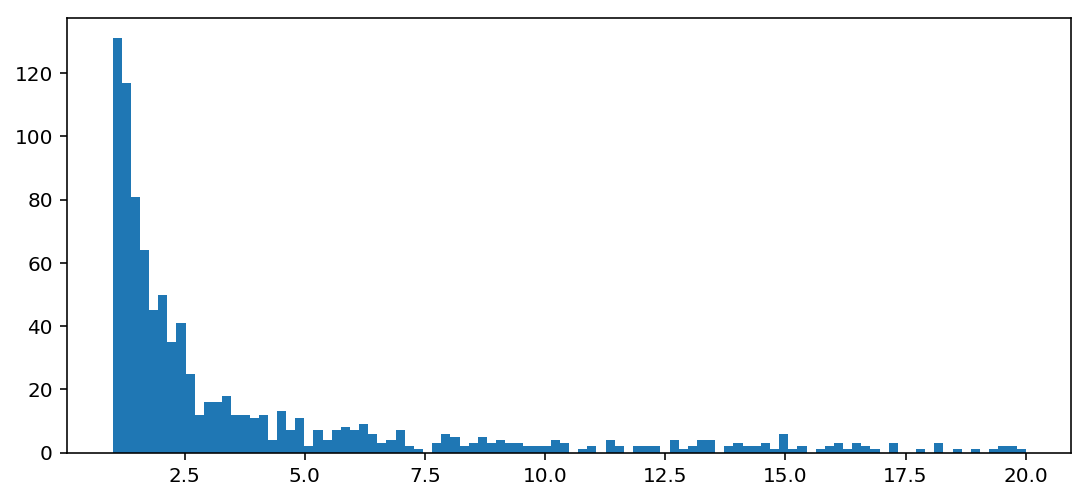

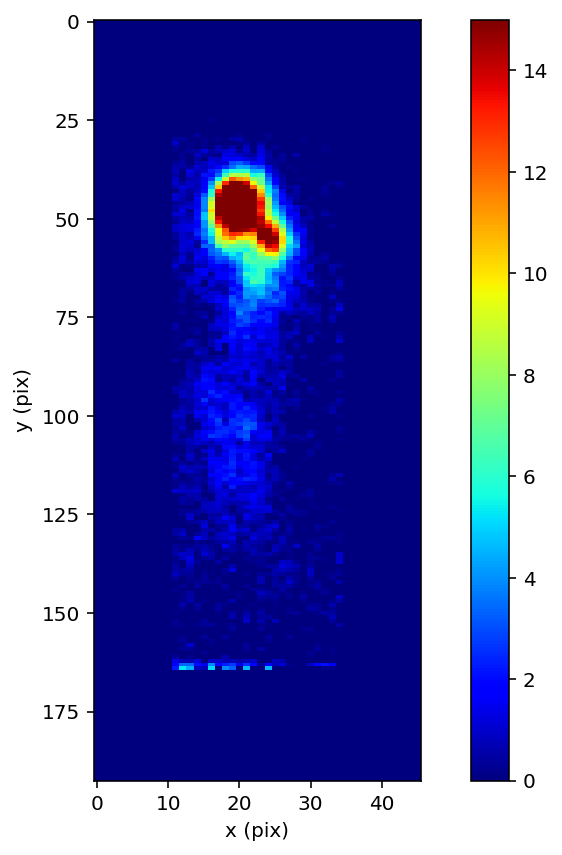

[28.81145059  8.1018769   2.77177745  5.59661264 -2.66157595]


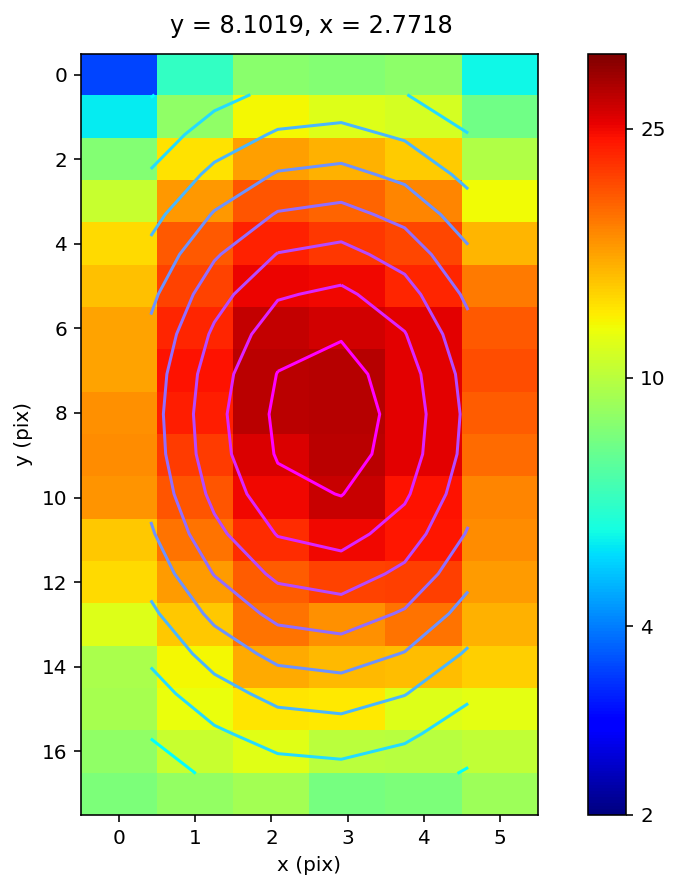

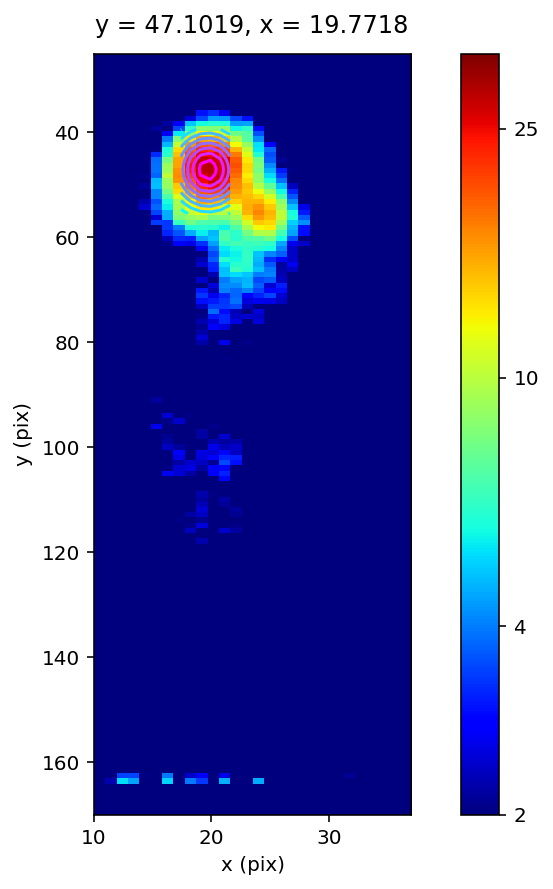

(47.10187690386637, 19.77177745097399)

In [5]:
sum_4340 = make_sum(4340.00, 4345.25, "blue1")
plot_hist(sum_4340, [1, 20])
plot_sum(sum_4340, 0, 15)
plt.show() 

plot_gaussian_fit(sum_4340, (39, 56, 17, 22), 2, 33, [2, 4, 10, 25])

In [6]:
image_2 = "HH32_170614/kb170614_00177_icubes.fits"

hdu_list_blue2, Min_blue2, Max_blue2, step_blue2, xlen, ylen = extract_FITS(image_2)
hdu_list_blue2.info()

print(Min_blue2, Max_blue2, step_blue2, xlen, ylen)

Filename: HH32_170614/kb170614_00177_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4514)   float32   
3462.25 4590.5 0.25 15.615252271222728 28.12550448853331


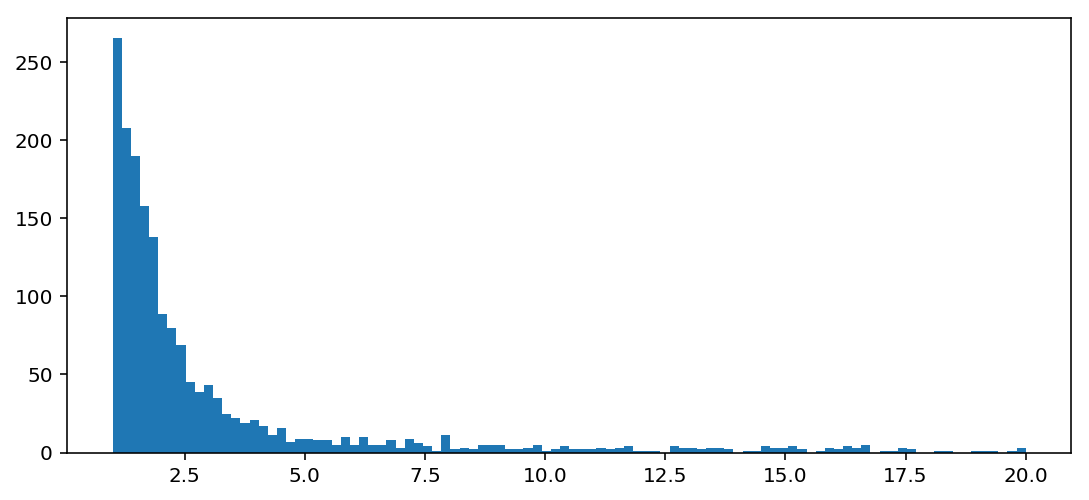

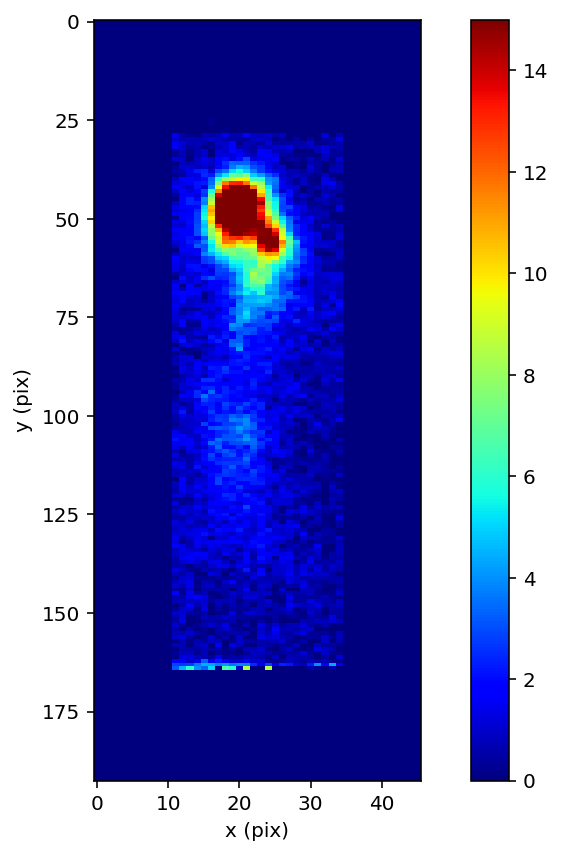

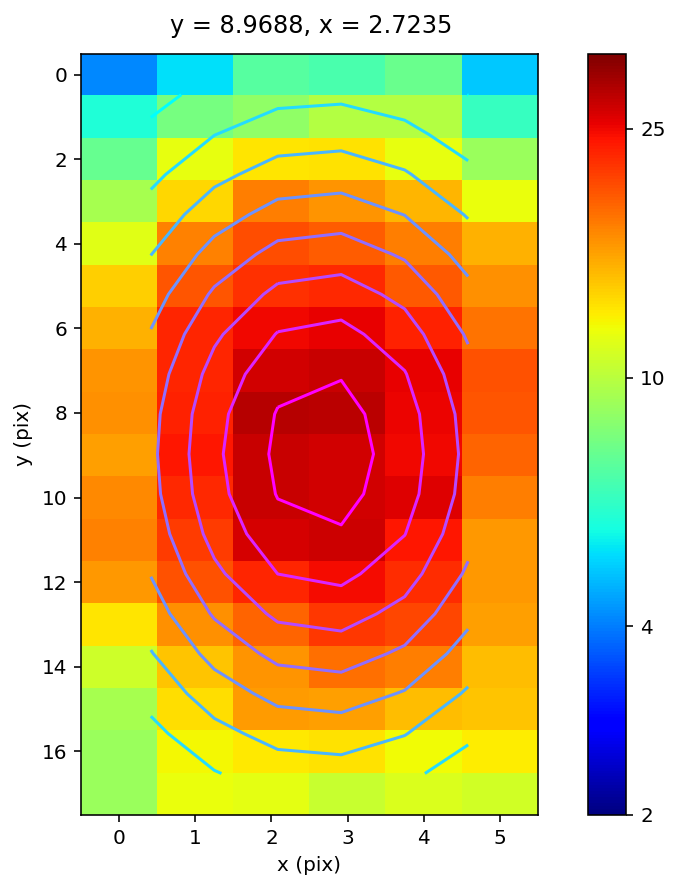

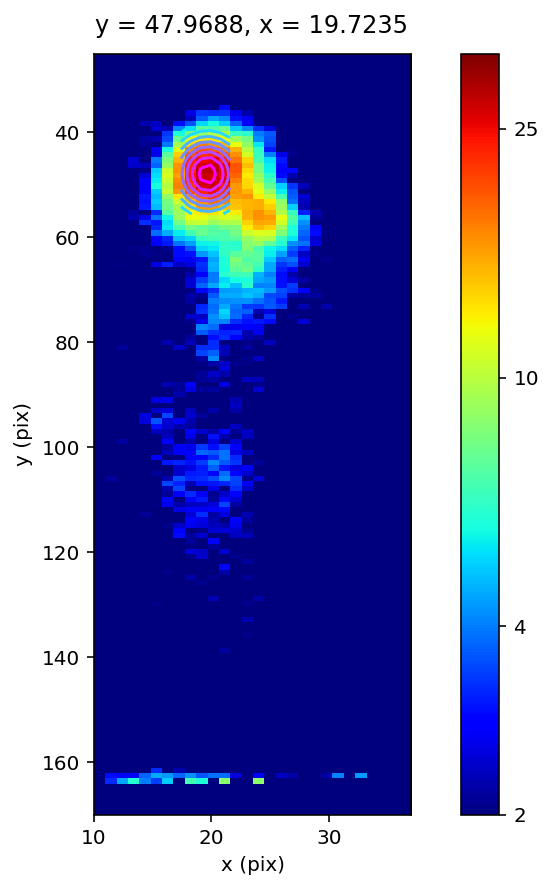

(47.968763785134996, 19.723502213755594)

In [7]:
sum_4340 = make_sum(4340.00, 4345.25, "blue2")
plot_hist(sum_4340, [1, 20])
plot_sum(sum_4340, 0, 15)
plt.show() 

plot_gaussian_fit(sum_4340, (39, 56, 17, 22), 2, 33, [2, 4, 10, 25])

In [8]:
image_3 = "HH32_170614/kb170614_00180_icubes.fits"

hdu_list_green1, Min_green1, Max_green1, step_green1, xlen, ylen = extract_FITS(image_3)
hdu_list_green1.info()

print(Min_green1, Max_green1, step_green1, xlen, ylen)

Filename: HH32_170614/kb170614_00180_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4374)   float32   
4156.25 5249.5 0.25 15.615252271222728 28.12550448853331


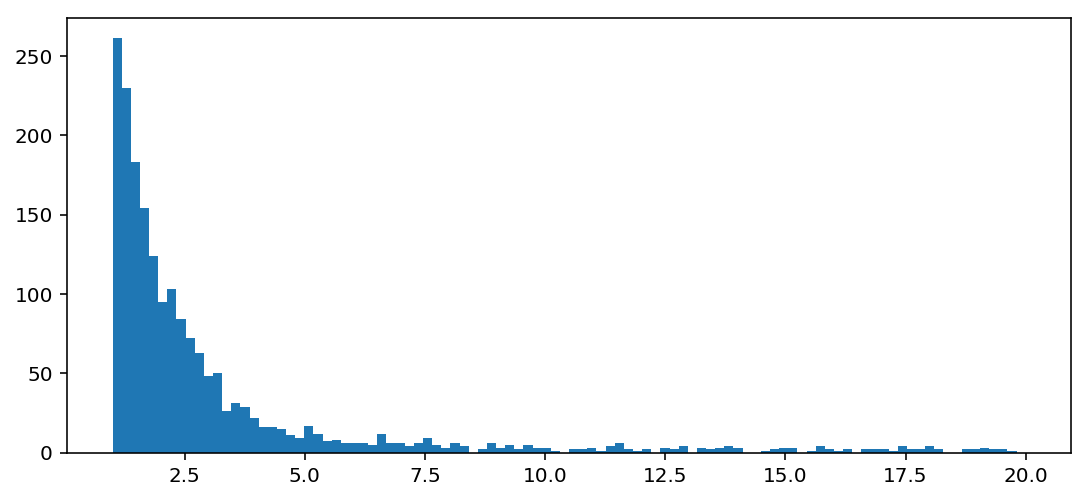

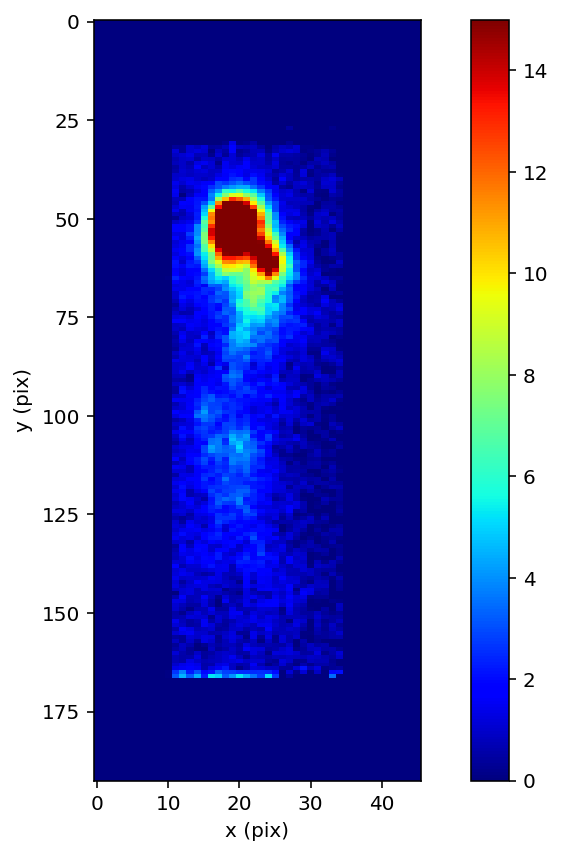

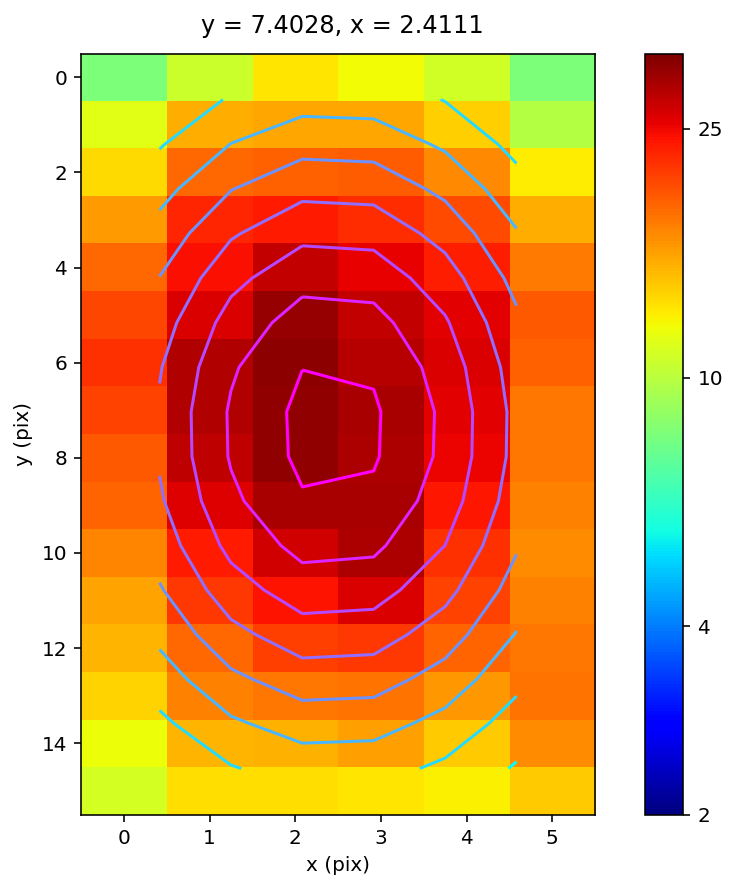

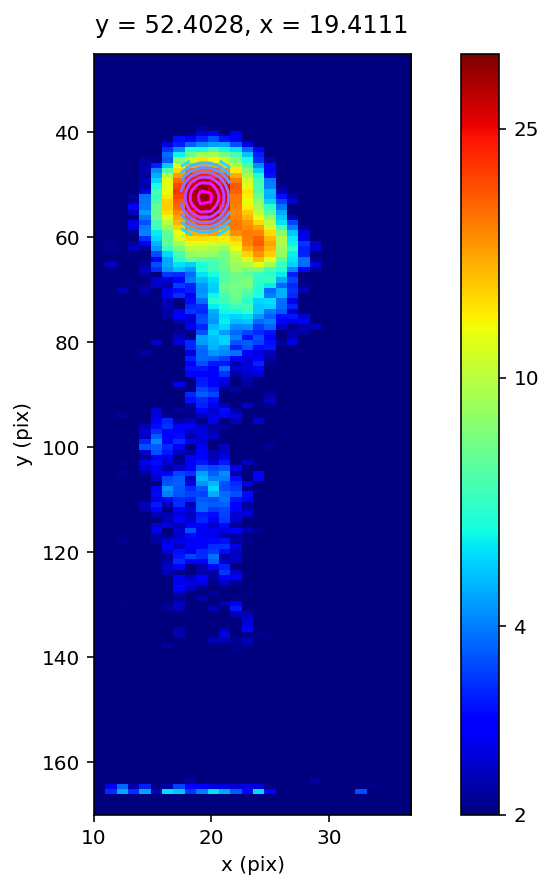

(52.40279309078596, 19.411099326611232)

In [9]:
sum_4340 = make_sum(4339.75, 4345.25, "green1")
plot_hist(sum_4340, [1, 20])
plot_sum(sum_4340, 0, 15)
plt.show() 

plot_gaussian_fit(sum_4340, (45, 60, 17, 22), 2, 33, [2, 4, 10, 25], 0.55)

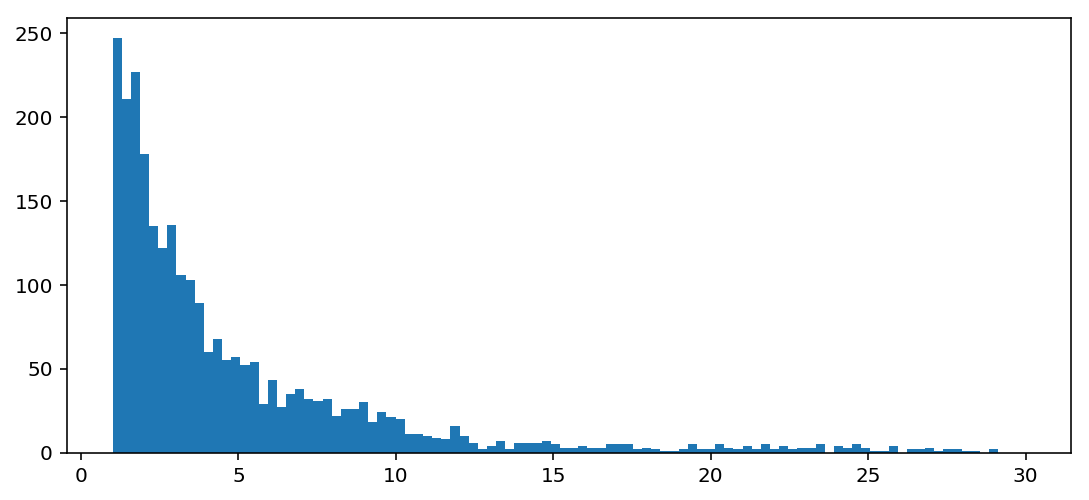

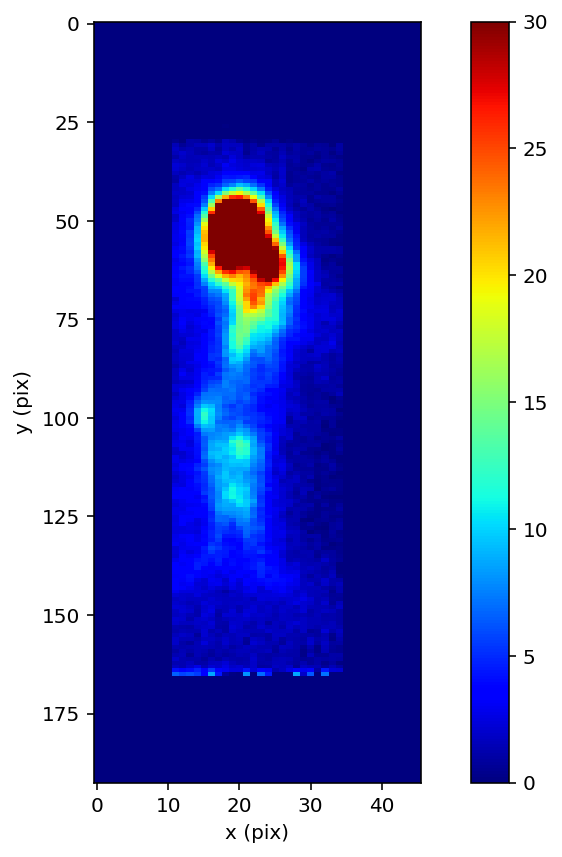

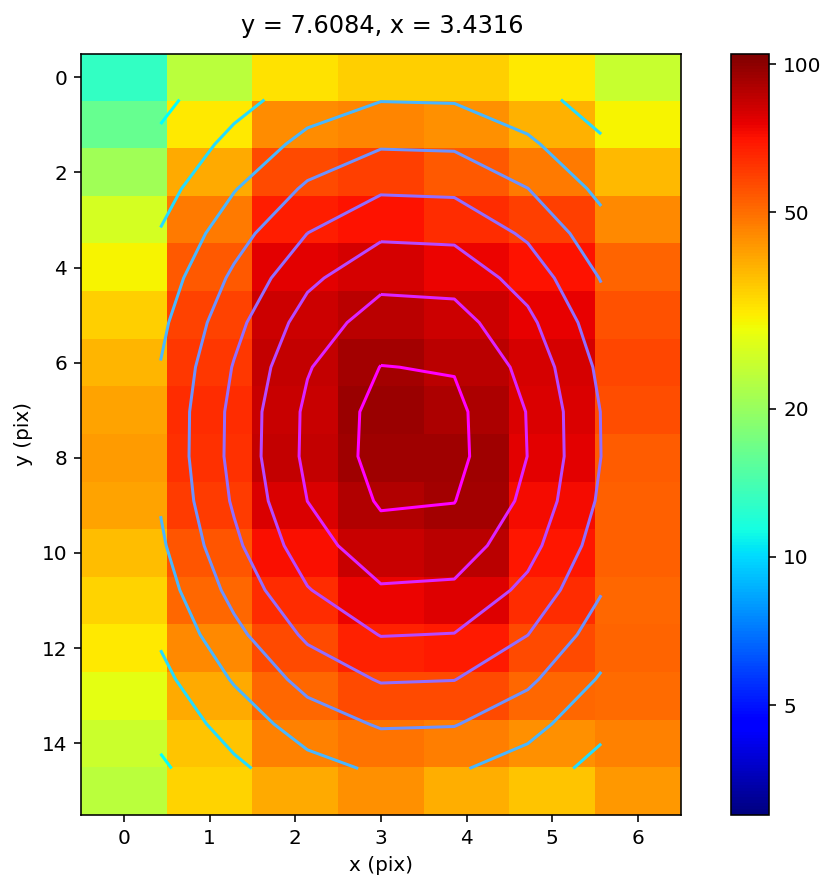

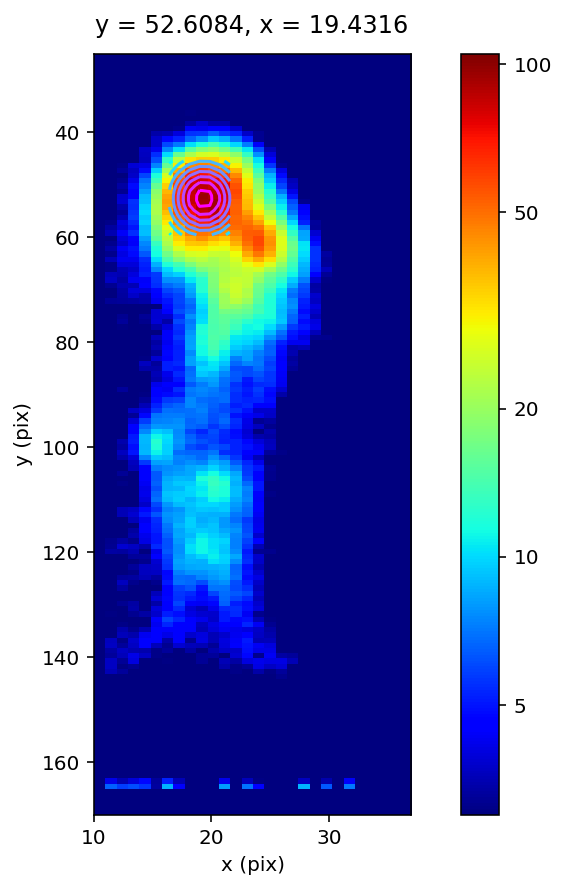

(52.60835874021569, 19.431632359323316)

In [10]:
sum_4861 = make_sum(4860.25, 4867.50, "green1")
plot_hist(sum_4861, [1, 30])
plot_sum(sum_4861, 0, 30)
plt.show()

plot_gaussian_fit(sum_4861, (45, 60, 16, 22), 3, 105, [5, 10, 20, 50, 100], 0.515)

In [11]:
image_4 = "HH32_170614/kb170614_00181_icubes.fits"

hdu_list_green2, Min_green2, Max_green2, step_green2, xlen, ylen = extract_FITS(image_4)
hdu_list_green2.info()

print(Min_green2, Max_green2, step_green2, xlen, ylen)

Filename: HH32_170614/kb170614_00181_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4374)   float32   
4156.25 5249.5 0.25 15.615252271222728 28.12550448853331


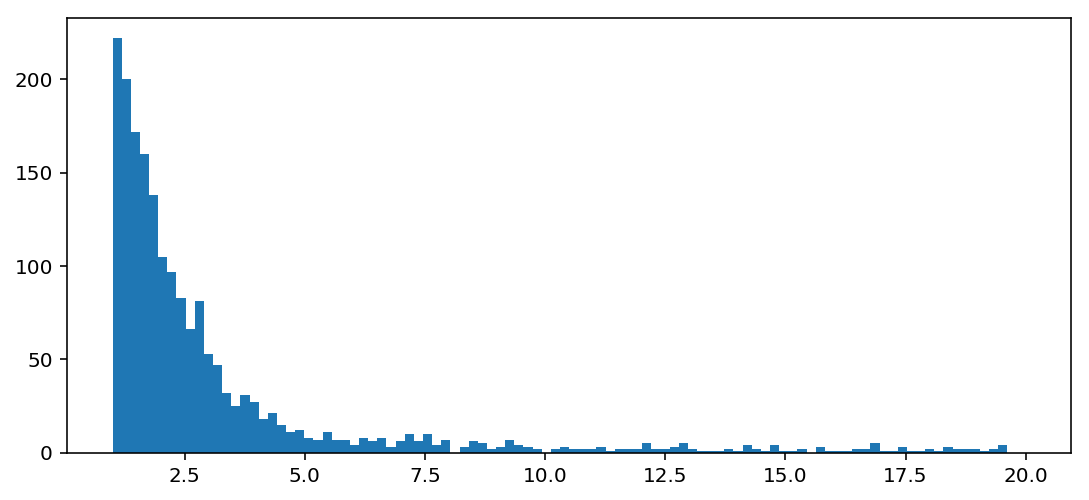

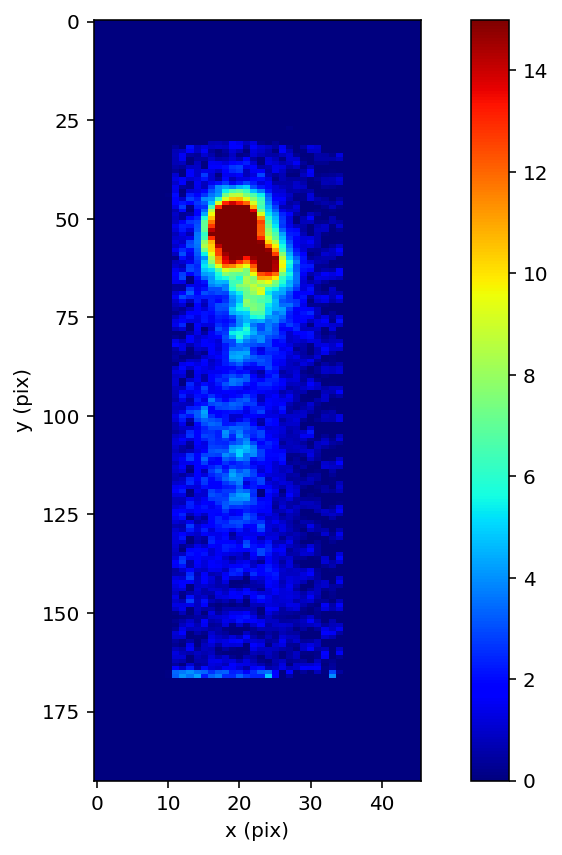

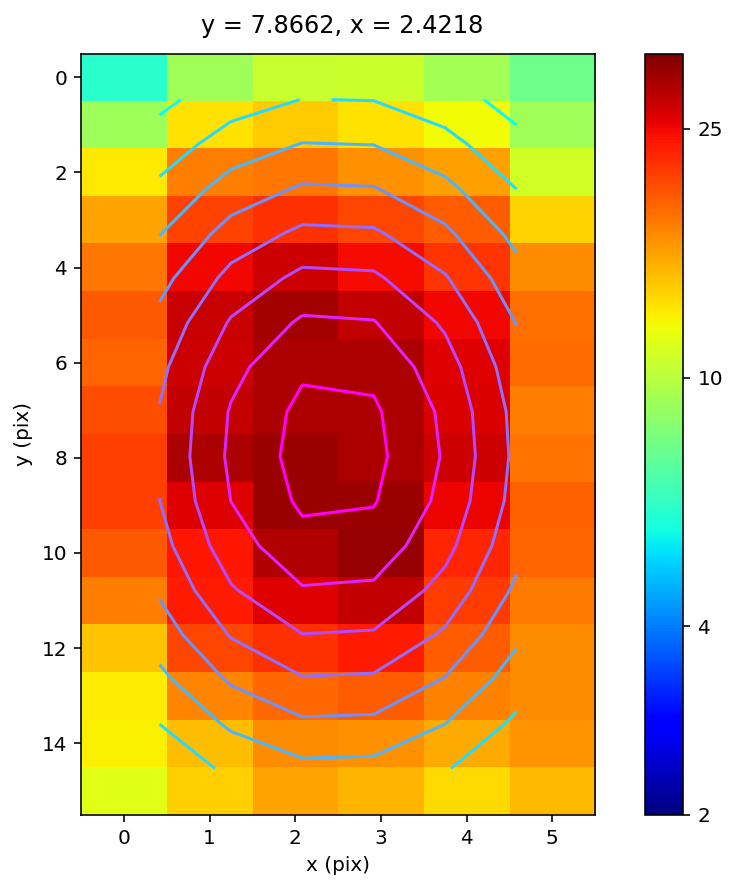

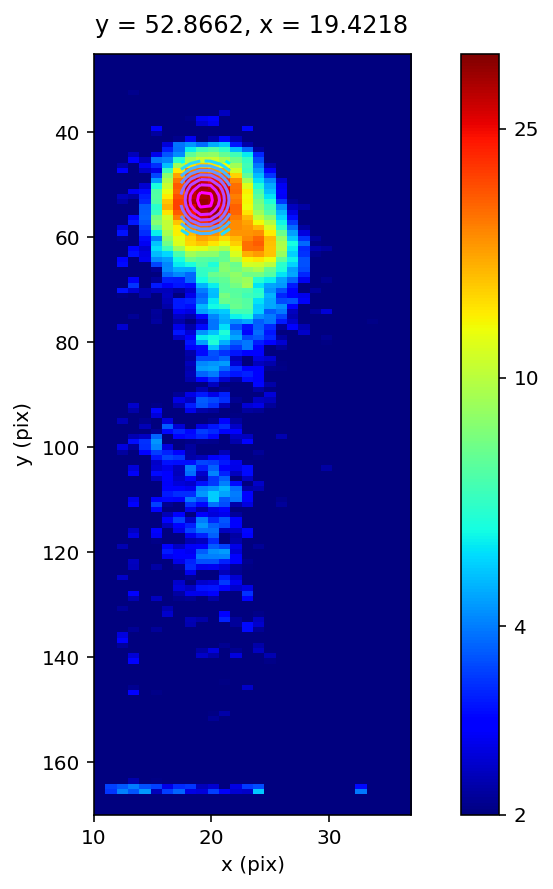

(52.86615958897427, 19.421776410010757)

In [12]:
sum_4340 = make_sum(4339.75, 4345.25, "green2")
plot_hist(sum_4340, [1, 20])
plot_sum(sum_4340, 0, 15)
plt.show()

plot_gaussian_fit(sum_4340, (45, 60, 17, 22), 2, 33, [2, 4, 10, 25], 0.55)

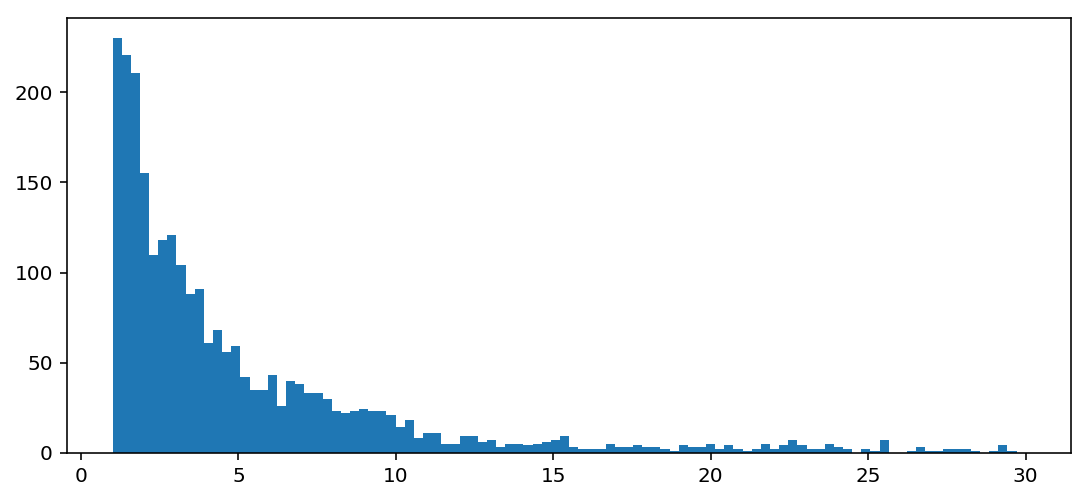

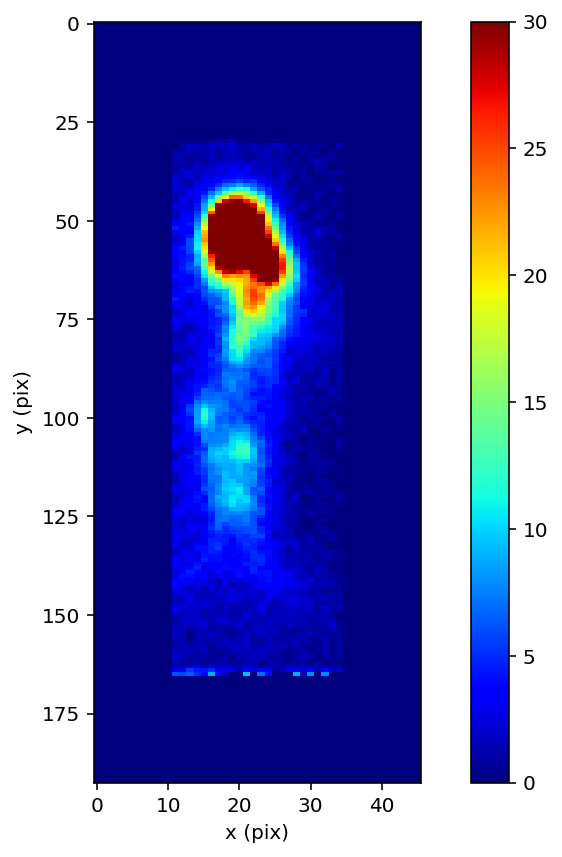

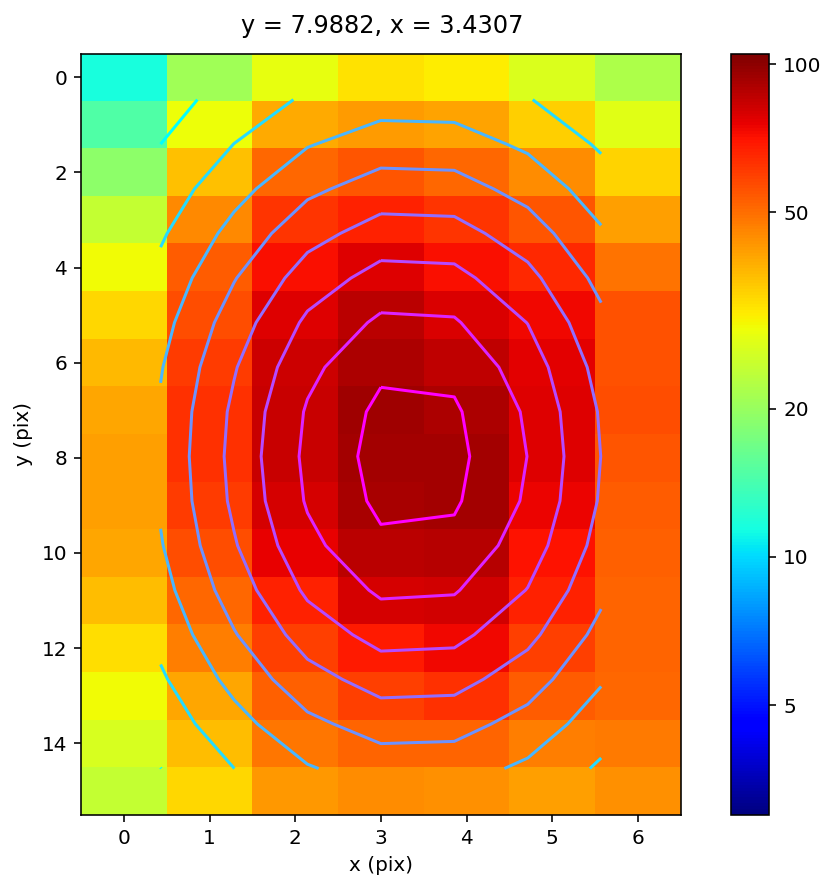

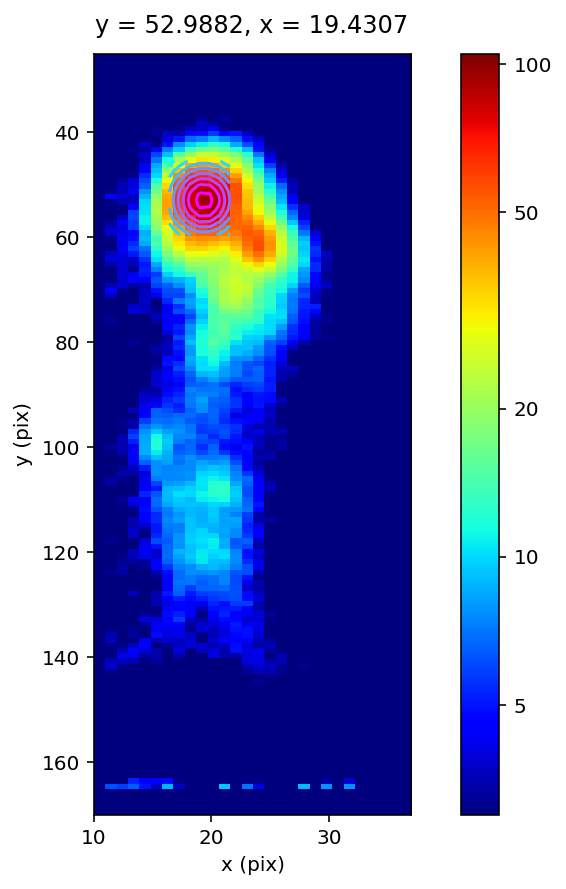

(52.988159337921545, 19.430714141542722)

In [13]:
sum_4861 = make_sum(4860.25, 4867.50, "green2")
plot_hist(sum_4861, [1, 30])
plot_sum(sum_4861, 0, 30)
plt.show()

plot_gaussian_fit(sum_4861, (45, 60, 16, 22), 3, 105, [5, 10, 20, 50, 100], 0.515)

In [14]:
image_5 = "HH32_170614/kb170614_00186_icubes.fits"

hdu_list_red1, Min_red1, Max_red1, step_red1, xlen, ylen = extract_FITS(image_5)
hdu_list_red1.info()

print(Min_red1, Max_red1, step_red1, xlen, ylen)

Filename: HH32_170614/kb170614_00186_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4049)   float32   
5439.25 6451.25 0.25 15.615252271222728 28.12550448853331


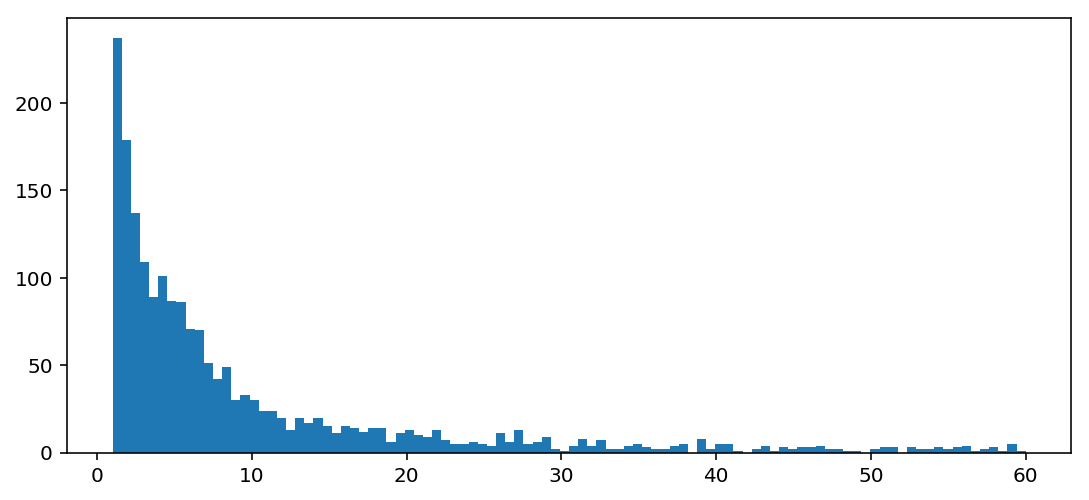

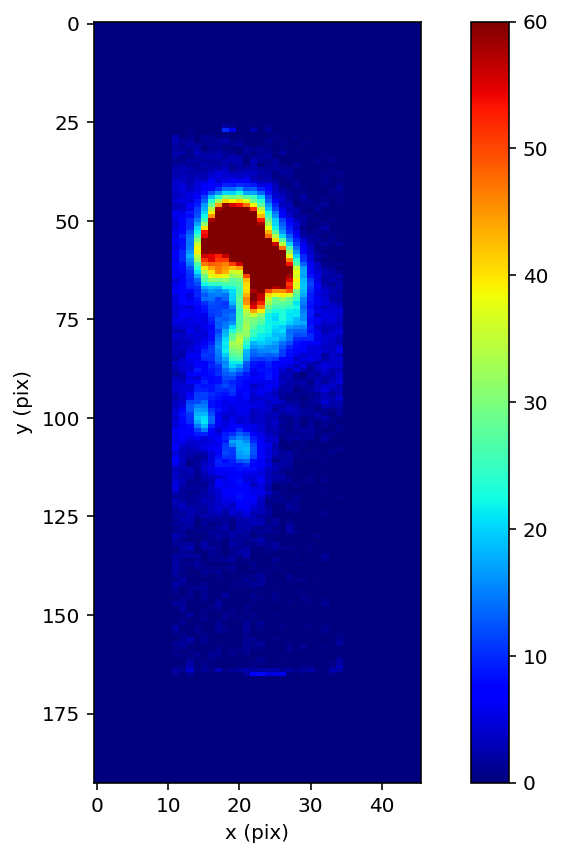

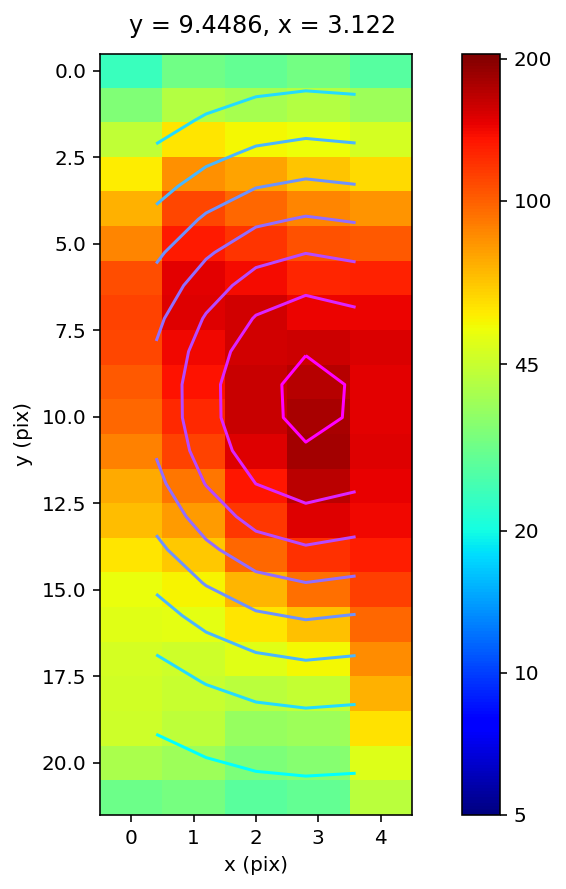

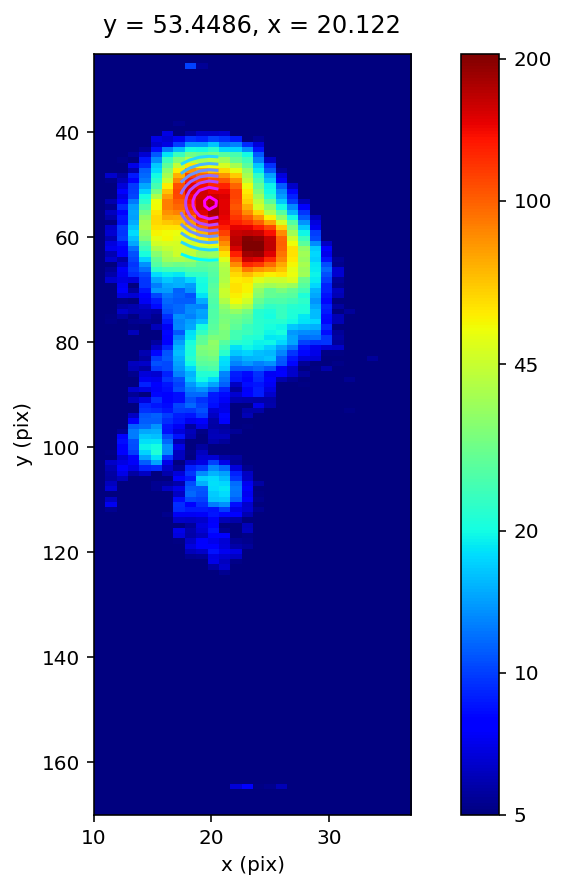

(53.448550791178434, 20.121992420676047)

In [15]:
sum_6300 = make_sum(6299.50, 6308.25, "red1")
plot_hist(sum_6300, [1, 60])
plot_sum(sum_6300, 0, 60)
plt.show()

plot_gaussian_fit(sum_6300, (44, 65, 17, 21), 5, 205, [5, 10, 20, 45, 100, 200], 0.63)

In [16]:
image_6 = "HH32_170614/kb170614_00187_icubes.fits"

hdu_list_red2, Min_red2, Max_red2, step_red2, xlen, ylen = extract_FITS(image_6)
hdu_list_red1.info()

print(Min_red2, Max_red2, step_red2, xlen, ylen)

Filename: HH32_170614/kb170614_00186_icubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     552   (46, 193, 4049)   float32   
5439.25 6451.25 0.25 15.615252271222728 28.12550448853331


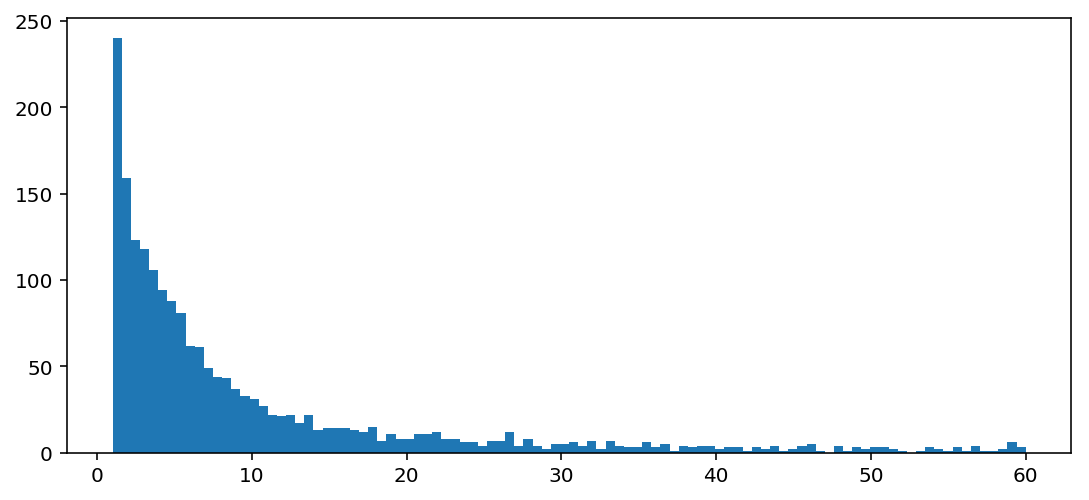

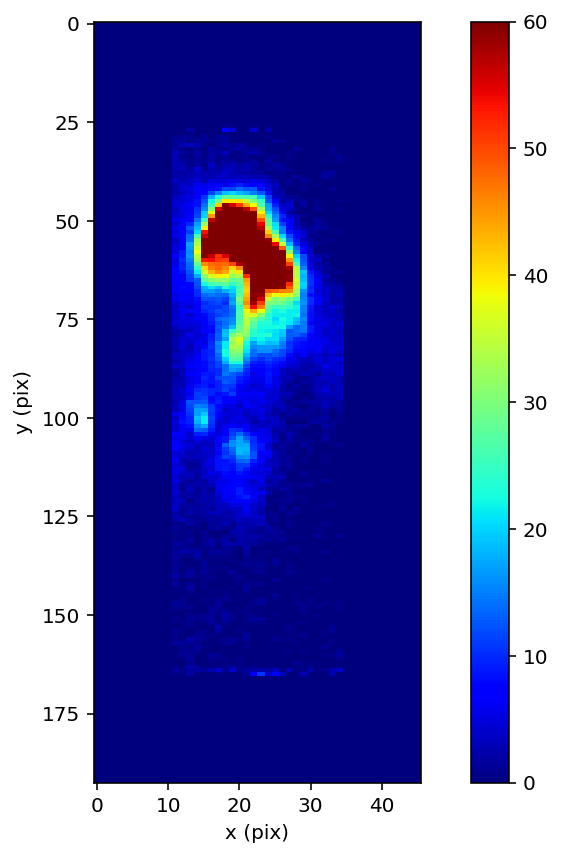

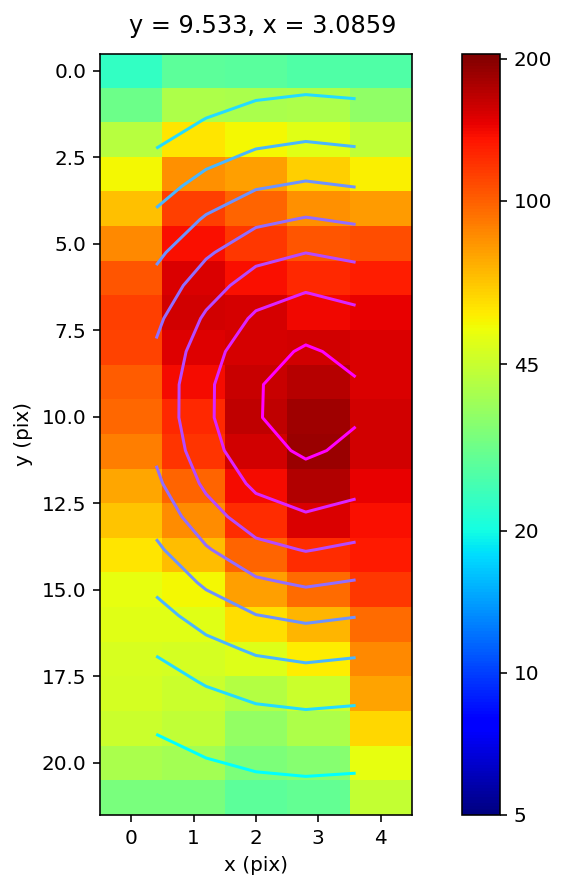

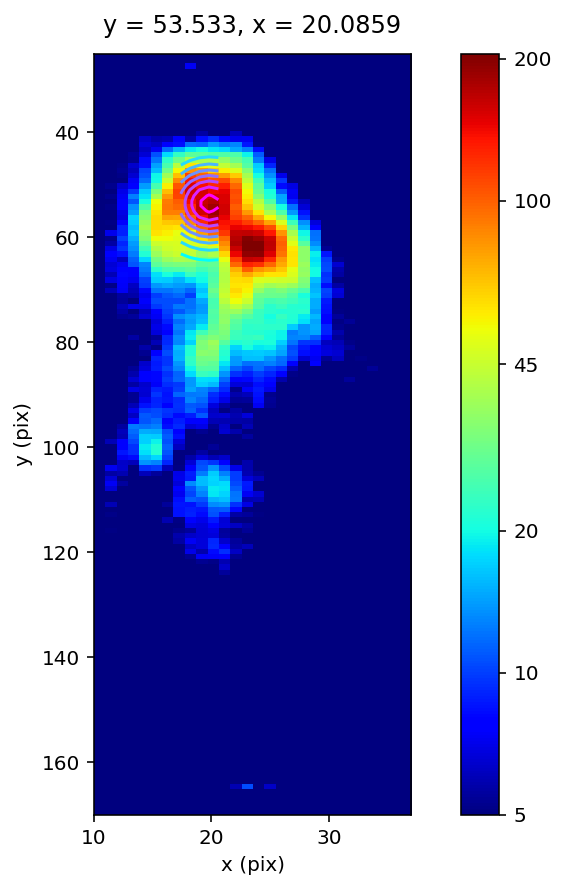

(53.532997385008784, 20.085883474072666)

In [17]:
sum_6300 = make_sum(6299.50, 6305.25, "red2")
plot_hist(sum_6300, [1, 60])
plot_sum(sum_6300, 0, 60)
plt.show()

plot_gaussian_fit(sum_6300, (44, 65, 17, 21), 5, 205, [5, 10, 20, 45, 100, 200], 0.63)